In [1]:
import pandas as pd
import os
import re
from datetime import datetime, timedelta
import cv2
import numpy as np
import matplotlib.pyplot as plt
from image_points import *
from read_positions import read_positions
import largestinteriorrectangle as lir
%matplotlib inline
from helper import *

def show(img):
    plt.figure()
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # change channels order since the YOLO work on BGR images


In [2]:
df = read_positions(label_dir='../../data/labels', output_csv='positions.csv')
df = df[df['Camera']==1]
df.head(11)

,Camera,Date,X_center,Y_center,Width,Height
22,1,2024-01-24 12:15:00,0.840104,0.5300,0.308333,0.524
23,1,2024-01-24 12:15:00,0.779948,0.2885,0.209896,0.365
36,1,2024-01-27 02:15:00,0.597135,0.7150,0.249479,0.562
37,1,2024-01-27 02:15:00,0.485677,0.5800,0.315104,0.334
112,1,2024-01-27 02:00:00,0.601302,0.7155,0.243229,0.553
113,1,2024-01-27 02:00:00,0.444792,0.5680,0.236458,0.340
121,1,2024-01-27 03:45:00,0.663281,0.7185,0.185938,0.325
122,1,2024-01-27 03:45:00,0.487760,0.6525,0.202604,0.307
123,1,2024-01-27 03:45:00,0.508594,0.8895,0.265104,0.211
134,1,2024-01-26 17:00:00,0.257292,0.1745,0.194792,0.255


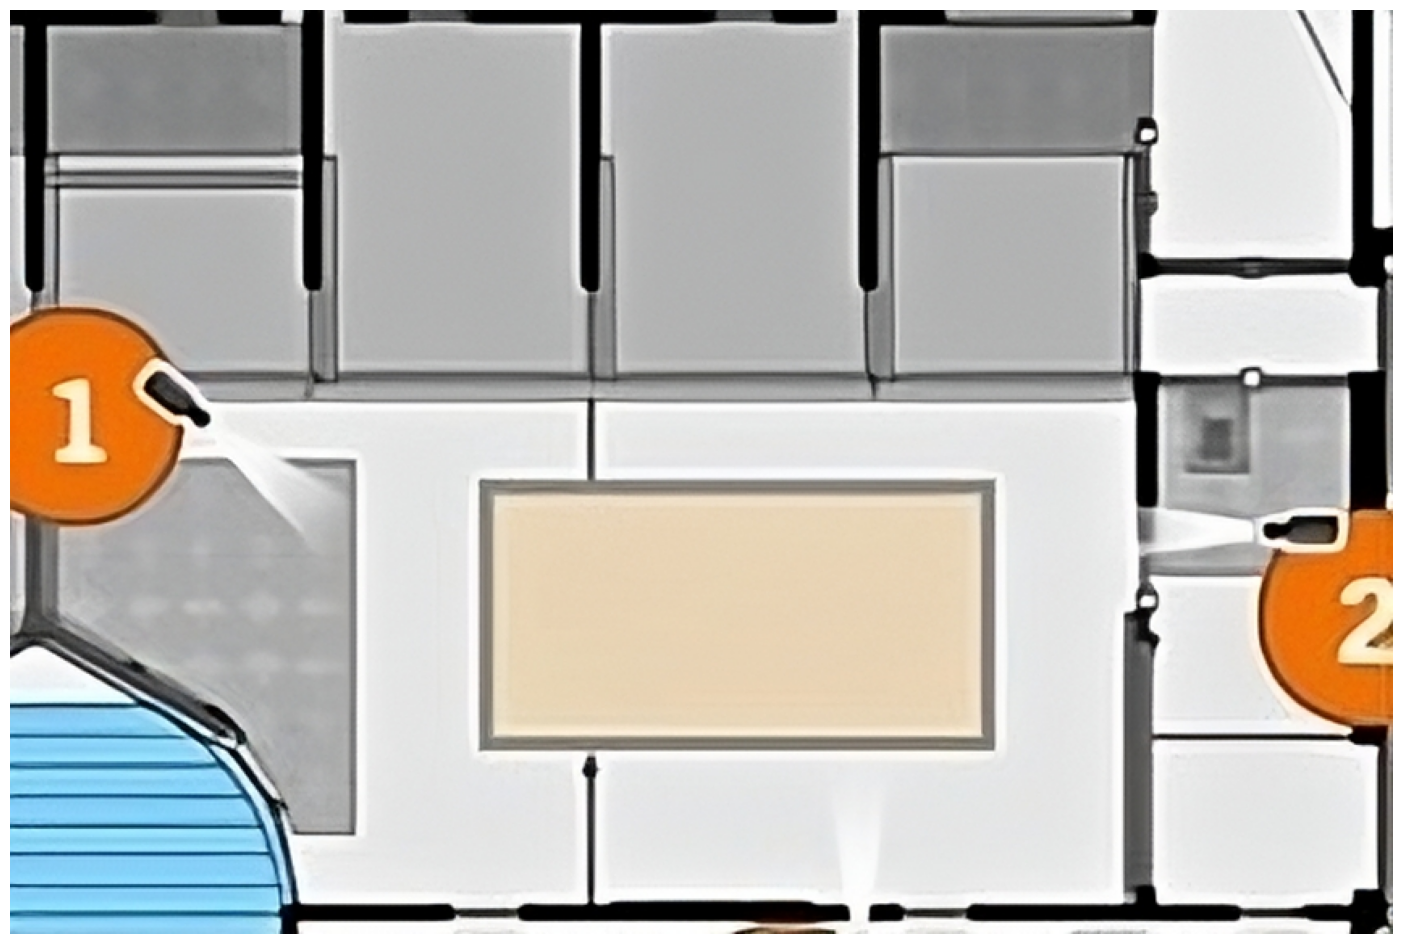

In [5]:
plot_images(background)

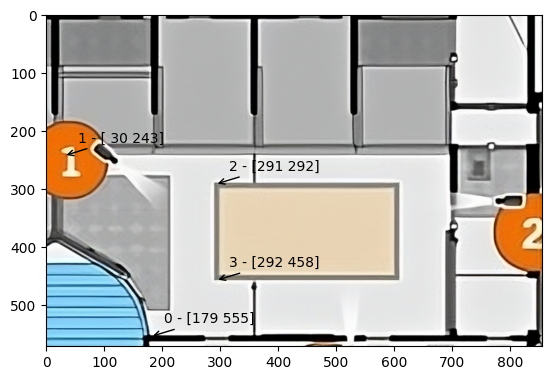

In [4]:
background = cv2.imread('back.jpeg')
show(background)
for i, pt in enumerate(MAP_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

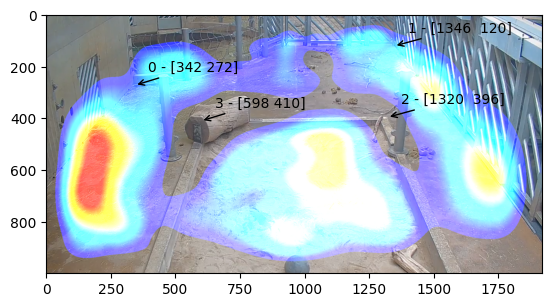

In [4]:
img = cv2.imread('heat.png')
show(img)
for i, pt in enumerate(IMAGE_PTS_1):
    plt.annotate(str(i) + " - " + str(pt), xy=pt, textcoords="offset points", xytext=(10,10), arrowprops=dict(arrowstyle="->"))

In [15]:
def transform_box(M, x, y, width, height):
    # x, y = x*1920, y*1000
    # width, height = width*1920, height*1000
    def transform_point(M, x, y):
        points = np.array([[x, y]], dtype='float32')  
        points_reshaped = np.array([points])
        pointsOut = cv2.perspectiveTransform(points_reshaped, H)
        return pointsOut[0,0,0], pointsOut[0,0,1]

    x_proj, y_proj = transform_point(M, x, y)
    
    left, right = x - width/2, x + width/2
    up, down = y - height/2, y + height/2

    upper_left_proj = transform_point(M, left, up)
    upper_right_proj = transform_point(M, right, up)
    lower_left_proj = transform_point(M, left, down)
    lower_right_proj = transform_point(M, right, down)
    polygon = np.array([[upper_left_proj, upper_right_proj, lower_right_proj, lower_left_proj]], np.int32)
    #print(f'POLYGON {polygon}')
    rectangle = lir.lir(polygon)
    x_proj, y_proj, width_proj, height_proj = rectangle
    x_proj += width_proj//2
    y_proj += height_proj//2
    return x_proj, y_proj, width_proj, height_proj


In [5]:
def transform_row(M, x, y, width, height):
    def transform_point(M, x, y):
        points = np.array([[x, y]], dtype='float32')  # Reshape and ensure it's float32
        points_reshaped = np.array([points])
        pointsOut = cv2.perspectiveTransform(points_reshaped, H)
        return pointsOut[0,0,0], pointsOut[0,0,1]

    x_prime, y_prime = transform_point(M, x, y)
    
    left, right = x - width/2, x + width/2
    left_prime = transform_point(M, left, y)
    right_prime = transform_point(M, right, y)
    width_prime = np.linalg.norm(np.array(left_prime)-np.array(right_prime))/1.5
    up, down = y - height/2, y + height/2
    up_prime = transform_point(M, x, up)
    down_prime = transform_point(M, x, down)
    height_prime = np.linalg.norm(np.array(up_prime)-np.array(down_prime))/1.5
    return x_prime,y_prime,width_prime, height_prime

In [42]:
def transform_row2(M, x, y, width, height, map_width, map_height):

    def transform_point(M, x, y):
        points = np.array([[x, y]], dtype='float32')  
        points_reshaped = np.array([points])
        pointsOut = cv2.perspectiveTransform(points_reshaped, H)
        return pointsOut[0,0,0], pointsOut[0,0,1]

    x_proj, y_proj = transform_point(M, x, y)
    
    left, right = x - width/2, x + width/2
    up, down = y - height/2, y + height/2

    upper_left_proj = transform_point(M, left, up)
    upper_right_proj = transform_point(M, right, up)
    lower_left_proj = transform_point(M, left, down)
    lower_right_proj = transform_point(M, right, down)
    leftiest_x = min(upper_left_proj[0], upper_right_proj[0], lower_left_proj[0], lower_right_proj[0])
    rightiest_x = max(upper_left_proj[0], upper_right_proj[0], lower_left_proj[0], lower_right_proj[0])

    highest_y = min(upper_left_proj[1], upper_right_proj[1], lower_left_proj[1], lower_right_proj[1])
    lowest_y = max(upper_left_proj[1], upper_right_proj[1], lower_left_proj[1], lower_right_proj[1])

    assert leftiest_x <= x_proj <= rightiest_x
    assert highest_y <= y_proj <= lowest_y
    
    width_proj = rightiest_x - leftiest_x
    height_proj = lowest_y - highest_y
    x_proj = (leftiest_x + rightiest_x)/2
    y_proj = (highest_y + lowest_y)/2

    if x_proj + width_proj/2 > map_width:
        diff = x_proj + width_proj/2 - map_width
        x_proj -= diff/2
        width_proj -= diff
    elif x_proj - width_proj/2 < 0:
        diff = width_proj/2 - x_proj
        x_proj += diff/2
        width_proj += diff

    if y_proj + height_proj/2 > map_height:
        diff = y_proj + height_proj/2 - map_height
        y_proj -= diff/2
        height_proj -= diff
    elif y_proj - height_proj/2 < 0:
        diff = height_proj/2 - y_proj
        y_proj += diff/2
        height_proj += diff
    
        
    return x_proj, y_proj, width_proj, height_proj

In [43]:
H, mask = cv2.findHomography(IMAGE_PTS_1, MAP_PTS_1)

df_proj = pd.DataFrame(columns=['Camera', 'Date', 'X_center', 'Y_center', 'Width', 'Height'])
for index, row in df.iterrows():
    data = {}
    data['Camera'] = row['Camera']
    data['Date'] = row['Date']
    x, y, width, height = row['X_center'], row['Y_center'], row['Width'], row['Height']
    x, y = x*IMG_WIDTH, y*IMG_HEIGHT
    width, height = width*IMG_WIDTH, height*IMG_HEIGHT
    # print(f'x, y, w, h = {x, y, width, height}')
    x_proj, y_proj, width_proj, height_proj = transform_row2(H, x, y, width, height, MAP_WIDTH12, MAP_HEIGHT12)
    #print(f'x, y, w, h = {x_proj, y_proj, width_proj, height_proj}')

    map_width, map_height = MAP_WIDTH12, MAP_HEIGHT12
    
    data['X_center'], data['Y_center'], data['Width'], data['Height'] = x_proj/map_width, y_proj/map_height, width_proj/map_width, height_proj/map_height
    # print(data)
    df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)
df_proj.head()

/tmp/ipykernel_733815/3637538971.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_proj = pd.concat([df_proj, pd.DataFrame([data])], ignore_index=True)


,Camera,Date,X_center,Y_center,Width,Height
0,1,2024-01-24 12:15:00,0.379946,0.391073,0.300610,0.327955
1,1,2024-01-24 12:15:00,0.200149,0.372670,0.384601,0.315371
2,1,2024-01-27 02:15:00,0.474378,0.582647,0.225153,0.180761
3,1,2024-01-27 02:15:00,0.429495,0.666172,0.171505,0.241169
4,1,2024-01-27 02:00:00,0.475651,0.579927,0.220646,0.174989


In [44]:
df_proj.head(11)

,Camera,Date,X_center,Y_center,Width,Height
0,1,2024-01-24 12:15:00,0.379946,0.391073,0.300610,0.327955
1,1,2024-01-24 12:15:00,0.200149,0.372670,0.384601,0.315371
2,1,2024-01-27 02:15:00,0.474378,0.582647,0.225153,0.180761
3,1,2024-01-27 02:15:00,0.429495,0.666172,0.171505,0.241169
4,1,2024-01-27 02:00:00,0.475651,0.579927,0.220646,0.174989
5,1,2024-01-27 02:00:00,0.422234,0.697662,0.179561,0.186504
6,1,2024-01-27 03:45:00,0.495944,0.552761,0.122229,0.124848
7,1,2024-01-27 03:45:00,0.468224,0.660904,0.133495,0.139608
8,1,2024-01-27 03:45:00,0.557434,0.645524,0.059489,0.137060
9,1,2024-01-26 17:00:00,0.124751,0.893238,0.650299,0.213523


572 856


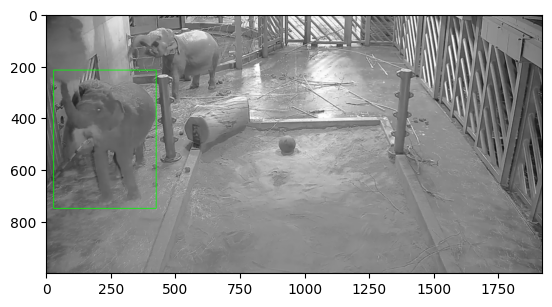

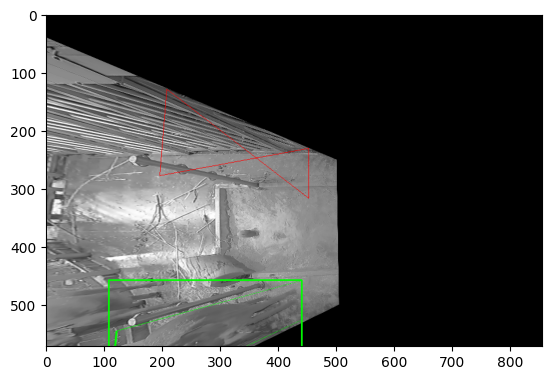

In [35]:
def plot_rectangle_on_image(image, cx, cy, w, h, color=(0, 255, 0), thickness=2):
    """
    Draws a rectangle on an image based on the center coordinates, width, and height.

    Parameters:
    - image: The image (numpy array) on which to draw.
    - cx, cy: The center coordinates of the rectangle.
    - w, h: The width and height of the rectangle.
    - color: The color of the rectangle (BGR format).
    - thickness: The thickness of the rectangle's outline. Use -1 for filled rectangle.
    """
    # Calculate the top-left corner of the rectangle
        
    top_left_x = int(cx - w / 2)
    top_left_y = int(cy - h / 2)

    # Calculate the bottom-right corner of the rectangle
    bottom_right_x = int(cx + w / 2)
    bottom_right_y = int(cy + h / 2)

    # Draw the rectangle on the image
    cv2.rectangle(image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color, thickness)


# Example usage:
image = cv2.imread('../../data/images/screenshot1_26_01__16_00.png')
x,y,z, h = 0.119010,	0.4830,	0.206771,	0.534
plot_rectangle_on_image(image, x*1920, y*1000, z*1920, h*1000)
show(image)
# Plot a rectangle on the image
# plot_rectangle_on_image(image, cx=100, cy=150, w=50, h=100, color=(255, 0, 0), thickness=2)

# Show the image with the rectangle
# cv2.imshow('Image with Rectangle', image)
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(image, H, (width, height))

a,b,c,d = 0.32142, 0.997913,0.38915, 0.393189

plot_rectangle_on_image(dst,a*MAP_WIDTH12, b*MAP_HEIGHT12, c*MAP_WIDTH12,	d*MAP_HEIGHT12)
polygon = np.array([[196, 278],
  [208, 129],
  [453, 317],
  [453, 231]])
cv2.polylines(dst, [polygon], True, (0, 0, 255), 1)

show(dst)

572 856


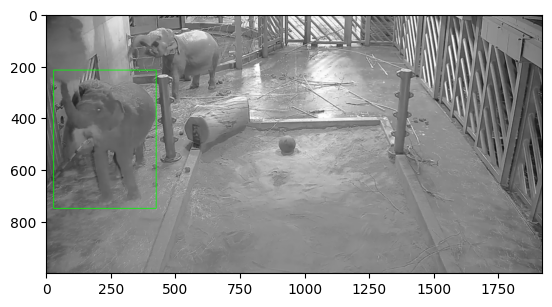

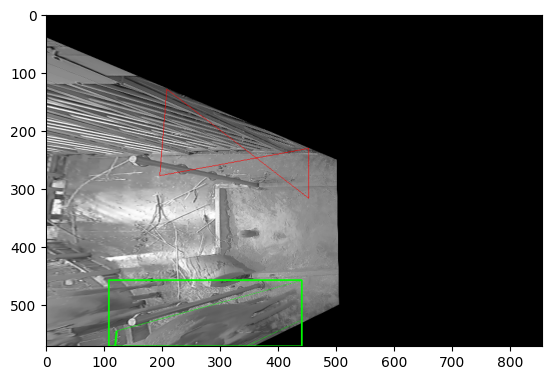

In [36]:
def plot_rectangle_on_image(image, cx, cy, w, h, color=(0, 255, 0), thickness=2):
    """
    Draws a rectangle on an image based on the center coordinates, width, and height.

    Parameters:
    - image: The image (numpy array) on which to draw.
    - cx, cy: The center coordinates of the rectangle.
    - w, h: The width and height of the rectangle.
    - color: The color of the rectangle (BGR format).
    - thickness: The thickness of the rectangle's outline. Use -1 for filled rectangle.
    """
    # Calculate the top-left corner of the rectangle
        
    top_left_x = int(cx - w / 2)
    top_left_y = int(cy - h / 2)

    # Calculate the bottom-right corner of the rectangle
    bottom_right_x = int(cx + w / 2)
    bottom_right_y = int(cy + h / 2)

    # Draw the rectangle on the image
    cv2.rectangle(image, (top_left_x, top_left_y), (bottom_right_x, bottom_right_y), color, thickness)


# Example usage:
image = cv2.imread('../../data/images/screenshot1_26_01__16_00.png')
x,y,z, h = 0.119010,	0.4830,	0.206771,	0.534
plot_rectangle_on_image(image, x*1920, y*1000, z*1920, h*1000)
show(image)
# Plot a rectangle on the image
# plot_rectangle_on_image(image, cx=100, cy=150, w=50, h=100, color=(255, 0, 0), thickness=2)

# Show the image with the rectangle
# cv2.imshow('Image with Rectangle', image)
height, width = background.shape[:2]
print(height, width)
dst = cv2.warpPerspective(image, H, (width, height))

a,b,c,d = 0.321421,	0.900659,	0.389158,	0.198682,

plot_rectangle_on_image(dst,a*MAP_WIDTH12, b*MAP_HEIGHT12, c*MAP_WIDTH12,	d*MAP_HEIGHT12)
polygon = np.array([[196, 278],
  [208, 129],
  [453, 317],
  [453, 231]])
cv2.polylines(dst, [polygon], True, (0, 0, 255), 1)

show(dst)

In [50]:
def get_heatmap_new(df, camera):
    df = df[df['Camera'] == camera]

    # Specify the dimensions of the heatmap
    heatmap_width, heatmap_height = 856, 572

    # Initialize a blank image for the heatmap
    heatmap_img = np.zeros((heatmap_height, heatmap_width), dtype=np.float32)

    # Function to apply intensity within the bounding box area
    def apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap):
        # Calculate the bounding box in pixel coordinates
        left = int(max(0, cx - w * heatmap_width / 2))
        right = int(min(heatmap_width, cx + w * heatmap_width / 2))
        top = int(max(0, cy - h * heatmap_height / 2))
        bottom = int(min(heatmap_height, cy + h * heatmap_height / 2))

        sigma_x = w * heatmap_width / 6
        sigma_y = h * heatmap_height / 6

        # Apply intensity only within the bounding box, using a Gaussian distribution
        for y in range(top, bottom):
            for x in range(left, right):
                dx = cx - x
                dy = cy - y
                value = np.exp(-(dx ** 2 / (2 * sigma_x ** 2) + dy ** 2 / (2 * sigma_y ** 2)))
                heatmap[y, x] += value

    # Populate the heatmap with bounded Gaussian distribution
    for index, row in df.iterrows():
        cx, cy, w, h = row['X_center'] * heatmap_width, row['Y_center'] * heatmap_height, row['Width'], row['Height']
        apply_bounded_gaussian_heatmap(cx, cy, w, h, heatmap_img)

    # Normalize the heatmap
    cv2.normalize(heatmap_img, heatmap_img, 0, 255, norm_type=cv2.NORM_MINMAX)
    zero_mask = (heatmap_img < 30)
    # Apply a colormap to create a color heatmap
    heatmap_color = cv2.applyColorMap(np.uint8(heatmap_img), cv2.COLORMAP_JET)
    heatmap_color[zero_mask] = (0,0,0)
    # plt.figure()
    # plt.imshow(heatmap_color[..., ::-1])  # change channels order since the YOLO work on BGR images
    # plt.show()
    return heatmap_color


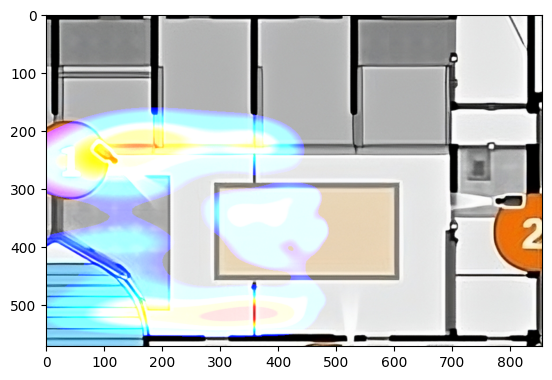

In [51]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_proj, 1)
overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()


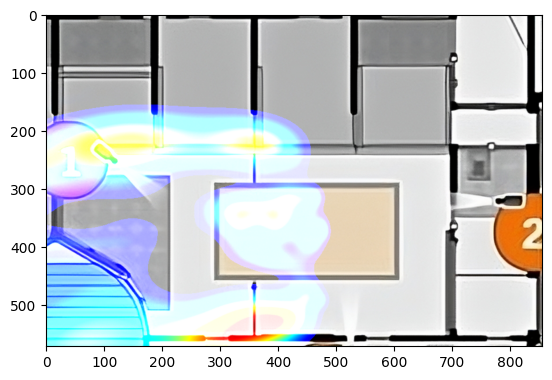

In [41]:
# Optionally, load an actual image to overlay the heatmap on
original_img = cv2.imread('back.jpeg')
heatmap_color = get_heatmap_new(df_proj, 1)
overlayed_img = cv2.addWeighted(original_img, 1, heatmap_color, 1, 0)
plt.figure()
plt.imshow(overlayed_img[..., ::-1])  # change channels order since the YOLO work on BGR images
plt.show()
